In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from cpi import inflate
from tqdm.notebook import tqdm
import gender_guesser.detector as gender
import seaborn as sns
import numpy as np
from scipy.stats import kurtosis

# Read in raw data

In [12]:
dfs = []

for year in tqdm(range(1980, 2023)):
    path = f"../results/top100_{year}.json"
    temp = pd.read_json(path, orient=str)
    dfs.append(temp)

data = pd.concat(dfs, ignore_index=True)

  0%|          | 0/43 [00:00<?, ?it/s]

In [13]:
data.dtypes

link          object
title         object
cover         object
age           object
release       object
rating       float64
actors        object
directors     object
runtime        int64
genres        object
origin        object
budget       float64
boxoffice    float64
ratings       object
reviews       object
dtype: object

In [14]:
def calculate_kurtosis(ratings):
    ratings_values = np.array(list(ratings.values()))
    kurtosis_value = kurtosis(ratings_values)
    return kurtosis_value

data['controversy_measure'] = data['ratings'].apply(calculate_kurtosis)

In [15]:
gd = gender.Detector(case_sensitive=False)

data['director_gender'] = data['directors'].apply(lambda x: str(x[0].split(" ")[0])).map(lambda x: gd.get_gender(x))
data['top_actor_gender'] = data['actors'].apply(lambda x: str(x[0].split(" ")[0])).map(lambda x: gd.get_gender(x))

In [16]:
data['director_gender'].value_counts()

director_gender
male             3546
unknown           239
female            230
mostly_male       193
mostly_female      51
andy               36
Name: count, dtype: int64

In [17]:
data['top_actor_gender'].value_counts()

top_actor_gender
male             2649
female            929
mostly_male       302
unknown           232
mostly_female     122
andy               61
Name: count, dtype: int64

In [18]:
data.loc[data['director_gender'] == 'unknown']

,link,title,cover,age,release,rating,actors,directors,runtime,genres,origin,budget,boxoffice,ratings,reviews,controversy_measure,director_gender,top_actor_gender
72,https://www.imdb.com/title/tt0081059,Omar Mukhtar - Löwe der Wüste,https://m.media-amazon.com/images/M/MV5BNGUxMD...,12,1981-10-29,8.2,"[Anthony Quinn, Oliver Reed, Rod Steiger]",[Moustapha Akkad],173,"[Biografie, Drama, Geschichte]",Vereinigte Staaten,35000000.0,NaN,"{'10': 6613, '9': 3126, '8': 3518, '7': 1790, ...","[{'rating': '9', 'text': '""Lion of the Desert""...",0.606856,unknown,male
96,https://www.imdb.com/title/tt0081764,Das Geheimnis der fliegenden Teufel,https://m.media-amazon.com/images/M/MV5BMWJmNz...,Not Rated,1980-11-26,5.1,"[Jack Palance, Martin Landau, Tarah Nutter]",[Greydon Clark],89,"[Horror, Science-Fiction, Thriller]",Vereinigte Staaten,150000.0,NaN,"{'10': 310, '9': 96, '8': 247, '7': 493, '6': ...","[{'rating': '5', 'text': 'This very weird driv...",-0.980225,unknown,male
139,https://www.imdb.com/title/tt0082484,Am Anfang war das Feuer,https://m.media-amazon.com/images/M/MV5BNjY1MG...,16,1982-03-04,7.3,"[Everett McGill, Ron Perlman, Nicholas Kadi]",[Jean-Jacques Annaud],100,"[Abenteuer, Drama]",Kanada,12500000.0,20962615.0,"{'10': 2688, '9': 2897, '8': 6474, '7': 6199, ...","[{'rating': '7', 'text': 'Jean-Jacques Annaud'...",-0.682046,unknown,male
143,https://www.imdb.com/title/tt0082269,Diva,https://m.media-amazon.com/images/M/MV5BZjZkOW...,12,1983-03-25,7.2,"[Wilhelmenia Fernandez, Frédéric Andréi, Rolan...",[Jean-Jacques Beineix],117,"[Krimi, Musikfilm, Thriller]",Frankreich,NaN,183425.0,"{'10': 1876, '9': 2034, '8': 3123, '7': 3085, ...","[{'rating': '10', 'text': 'Today, most films h...",-1.294148,unknown,unknown
158,https://www.imdb.com/title/tt0082970,Ragtime,https://m.media-amazon.com/images/M/MV5BZDdkYT...,12,1982-01-21,7.3,"[James Cagney, Elizabeth McGovern, Howard E. R...",[Milos Forman],155,[Drama],Vereinigte Staaten,NaN,14920781.0,"{'10': 955, '9': 1152, '8': 2709, '7': 2906, '...","[{'rating': '9', 'text': 'Back in the day when...",-0.582394,unknown,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4259,https://www.imdb.com/title/tt3704428,Elvis,https://m.media-amazon.com/images/M/MV5BM2FlZW...,6,2022-06-23,7.3,"[Tom Hanks, Austin Butler, Olivia DeJonge]",[Baz Luhrmann],159,"[Biografie, Drama, Musikfilm]",Vereinigte Staaten,85000000.0,288670284.0,"{'10': 25317, '9': 26468, '8': 58189, '7': 537...","[{'rating': '8', 'text': 'It's probably not th...",-0.747567,unknown,male
4260,https://www.imdb.com/title/tt15441472,The Price We Pay,https://m.media-amazon.com/images/M/MV5BNjcyNG...,18,2023-01-10,4.8,"[Emile Hirsch, Stephen Dorff, Gigi Zumbado]",[Ryûhei Kitamura],86,"[Action, Horror, Thriller]",Vereinigte Staaten,NaN,770.0,"{'10': 92, '9': 29, '8': 81, '7': 231, '6': 34...","[{'rating': '7', 'text': 'This is a decent one...",-0.204195,unknown,male
4269,https://www.imdb.com/title/tt12193804,Whitney Houston: I wanna dance with somebody,https://m.media-amazon.com/images/M/MV5BNmYwNj...,12,2022-12-22,6.6,"[Naomi Ackie, Stanley Tucci, Ashton Sanders]",[Kasi Lemmons],144,"[Biografie, Drama, Musikfilm]",Vereinigte Staaten,45000000.0,59761248.0,"{'10': 1635, '9': 1006, '8': 2877, '7': 4726, ...","[{'rating': '6', 'text': 'I like a biopic as m...",-0.463847,unknown,female
4278,https://www.imdb.com/title/tt12477480,Die Frau im Nebel,https://m.media-amazon.com/images/M/MV5BOTEzYT...,16,2023-02-02,7.3,"[Park Hae-il, Tang Wei, Lee Jung-hyun]",[Park Chan-wook],139,"[Krimi, Drama, Mystery]",Südkorea,10000000.0,22862606.0,"{'10': 2636, '9': 5427, '8': 12339, '7': 12386...","[{'rating': '7', 'text': 'The early films of P...",-0.603698,unknown,unknown


In [19]:
data = data.dropna(subset=['release'])

In [20]:
data['release'] = pd.to_datetime(data['release'])
data = data.loc[data['release'] <= pd.to_datetime('2022-12-31')]

In [21]:
data['release_year'] = data['release'].dt.year.astype(int)

In [22]:
# Inflation bereinigen
data['inflated_boxoffice'] = data.apply(lambda row: inflate(row['boxoffice'], row['release_year'], to=2022), axis=1)
data['inflated_budget'] = data.apply(lambda row: inflate(row['budget'], row['release_year'], to=2022), axis=1)

In [23]:
data.sort_values(by=["inflated_boxoffice"], ascending=False)

,link,title,cover,age,release,rating,actors,directors,runtime,genres,...,budget,boxoffice,ratings,reviews,controversy_measure,director_gender,top_actor_gender,release_year,inflated_boxoffice,inflated_budget
1697,https://www.imdb.com/title/tt0120338,Titanic,https://m.media-amazon.com/images/M/MV5BOGU0ZD...,12,1998-01-08,7.9,"[Leonardo DiCaprio, Kate Winslet, Billy Zane]",[James Cameron],194,"[Drama, Liebesfilm]",...,200000000.0,2.264743e+09,"{'10': 280444, '9': 201185, '8': 303051, '7': ...","[{'rating': '10', 'text': 'I have watched Tita...",-1.490011,male,male,1998,4.066187e+09,3.590859e+08
2899,https://www.imdb.com/title/tt0499549,Avatar - Aufbruch nach Pandora,https://m.media-amazon.com/images/M/MV5BZDA0OG...,12,2009-12-17,7.9,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron],162,"[Action, Abenteuer, Fantasy]",...,237000000.0,2.923706e+09,"{'10': 286144, '9': 250936, '8': 334480, '7': ...","[{'rating': '10', 'text': 'I was waiting for t...",-1.518050,male,mostly_male,2009,3.988297e+09,3.232973e+08
3900,https://www.imdb.com/title/tt4154796,Avengers: Endgame,https://m.media-amazon.com/images/M/MV5BMTc5MD...,12,2019-04-24,8.4,"[Robert Downey Jr., Chris Evans, Mark Ruffalo]","[Anthony Russo, Joe Russo]",181,"[Action, Abenteuer, Drama]",...,356000000.0,2.799439e+09,"{'10': 406702, '9': 263482, '8': 239194, '7': ...","[{'rating': '7', 'text': 'The soon-to-be most ...",-0.335287,male,male,2019,3.204566e+09,4.075194e+08
3504,https://www.imdb.com/title/tt2488496,Star Wars - Episode VII: Das Erwachen der Macht,https://m.media-amazon.com/images/M/MV5BYmI3ZD...,12,2015-12-17,7.8,"[Daisy Ridley, John Boyega, Oscar Isaac]",[J.J. Abrams],138,"[Action, Abenteuer, Science-Fiction]",...,245000000.0,2.071310e+09,"{'10': 165548, '9': 183440, '8': 249006, '7': ...","[{'rating': '7', 'text': 'This film really is ...",-1.332902,unknown,female,2015,2.557535e+09,3.025120e+08
204,https://www.imdb.com/title/tt0083866,E.T. - Der Außerirdische,https://m.media-amazon.com/images/M/MV5BYzljMz...,6,1982-12-09,7.9,"[Henry Thomas, Drew Barrymore, Peter Coyote]",[Steven Spielberg],115,"[Abenteuer, Familienfilm, Science-Fiction]",...,10500000.0,7.929106e+08,"{'10': 68206, '9': 69020, '8': 132137, '7': 88...","[{'rating': '8', 'text': 'E.T. THE EXTRA-TERRE...",-0.627743,male,male,1982,2.404655e+09,3.184329e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,https://www.imdb.com/title/tt11866324,Prey,https://m.media-amazon.com/images/M/MV5BMDBlMD...,16,2022-08-05,7.1,"[Amber Midthunder, Dakota Beavers, Dane DiLiegro]",[Dan Trachtenberg],100,"[Action, Abenteuer, Drama]",...,65000000.0,NaN,"{'10': 18613, '9': 20965, '8': 55085, '7': 623...","[{'rating': '7', 'text': 'Confession: I'm the ...",-0.418886,male,female,2022,NaN,6.500000e+07
4279,https://www.imdb.com/title/tt2935622,The School for Good and Evil,https://m.media-amazon.com/images/M/MV5BNzM1OD...,12,2022-10-19,5.8,"[Kit Young, Sophia Anne Caruso, Cate Blanchett]",[Paul Feig],147,"[Action, Komödie, Drama]",...,NaN,NaN,"{'10': 3185, '9': 1494, '8': 3417, '7': 5851, ...","[{'rating': '8', 'text': 'I've never read the ...",-0.996417,male,mostly_male,2022,NaN,NaN
4283,https://www.imdb.com/title/tt17076046,Weird: Die Al Yankovic Story,https://m.media-amazon.com/images/M/MV5BOWRiNm...,TV-14,2022-11-04,6.9,"[Diedrich Bader, Daniel Radcliffe, Lin-Manuel ...",[Eric Appel],108,"[Komödie, Krimi, Musikfilm]",...,8000000.0,NaN,"{'10': 3432, '9': 2558, '8': 6176, '7': 8781, ...","[{'rating': '10', 'text': 'Daniel Radcliffe is...",-0.317979,male,male,2022,NaN,8.000000e+06
4293,https://www.imdb.com/title/tt13610562,The Bubble,https://m.media-amazon.com/images/M/MV5BZWRiMD...,16,2022-04-01,4.7,"[Harry Trevaldwyn, Samson Kayo, Peter Serafino...",[Judd Apatow],126,[Komödie],...,NaN,NaN,"{'10': 1200, '9': 497, '8': 1415, '7': 2805, '...","[{'rating': '8', 'text': 'Well let me be the g...",-1.119390,male,male,2022,NaN,NaN


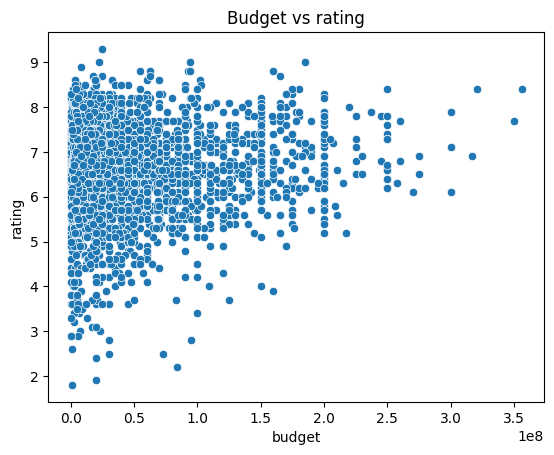

In [24]:
sns.scatterplot(data=data, x="budget", y="rating")

plt.title("Budget vs rating")
plt.show()

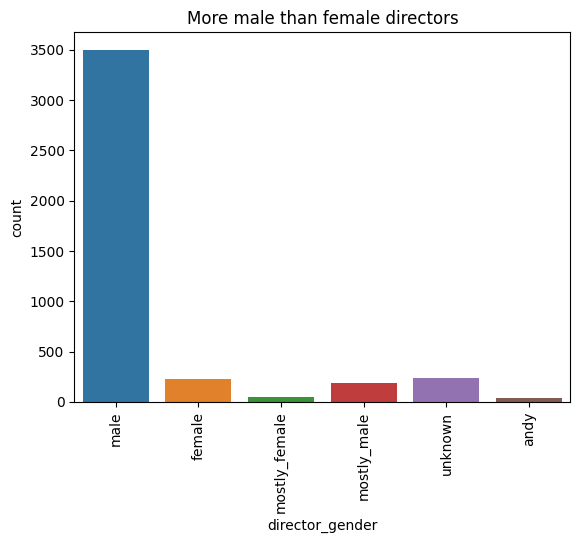

In [25]:
ax = sns.countplot(data=data, x="director_gender")

for item in ax.get_xticklabels():
    item.set_rotation(90)

plt.title("More male than female directors")
plt.show()

In [26]:
a = data.groupby('release_year')['director_gender'].unique()
pd.DataFrame.from_records(a.values.tolist()).stack().value_counts()

male             43
mostly_male      43
unknown          43
female           41
mostly_female    28
andy             23
Name: count, dtype: int64

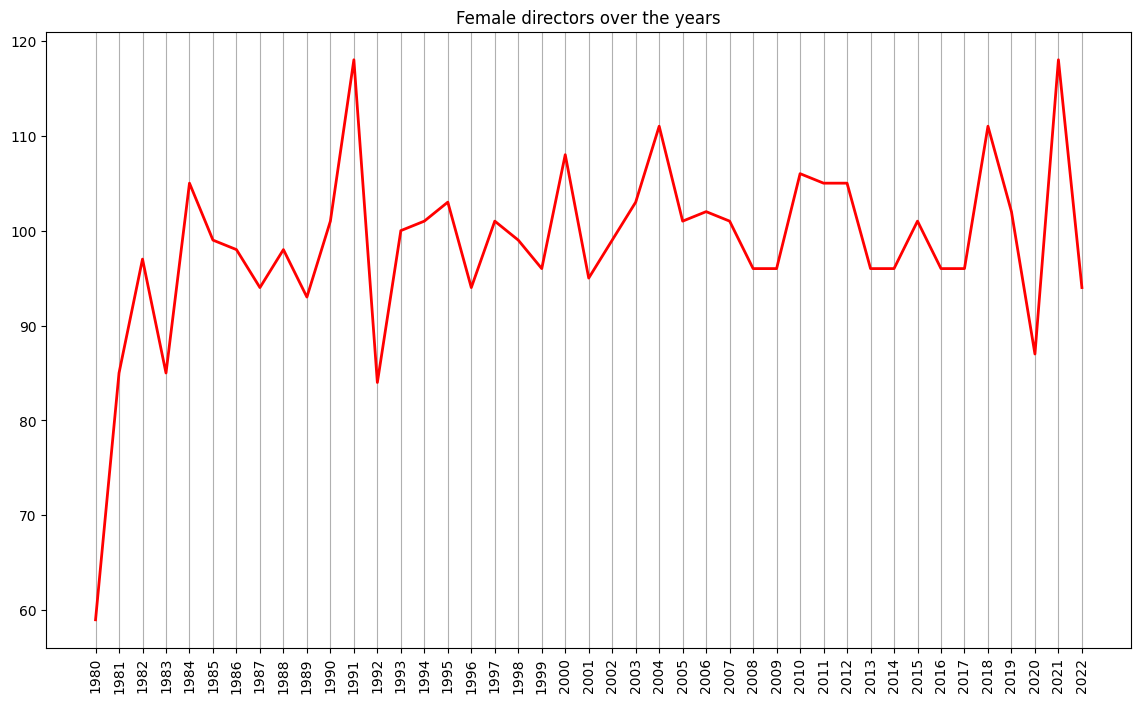

In [27]:
plt.figure(figsize=(14,8))

counts = data.groupby('release_year')['director_gender'].count()
ax = plt.plot(counts.index, counts, color='red', linestyle='-', linewidth=2)

plt.grid(axis='x')
plt.xticks(counts.index, rotation=90)
plt.title("Female directors over the years")
plt.show()

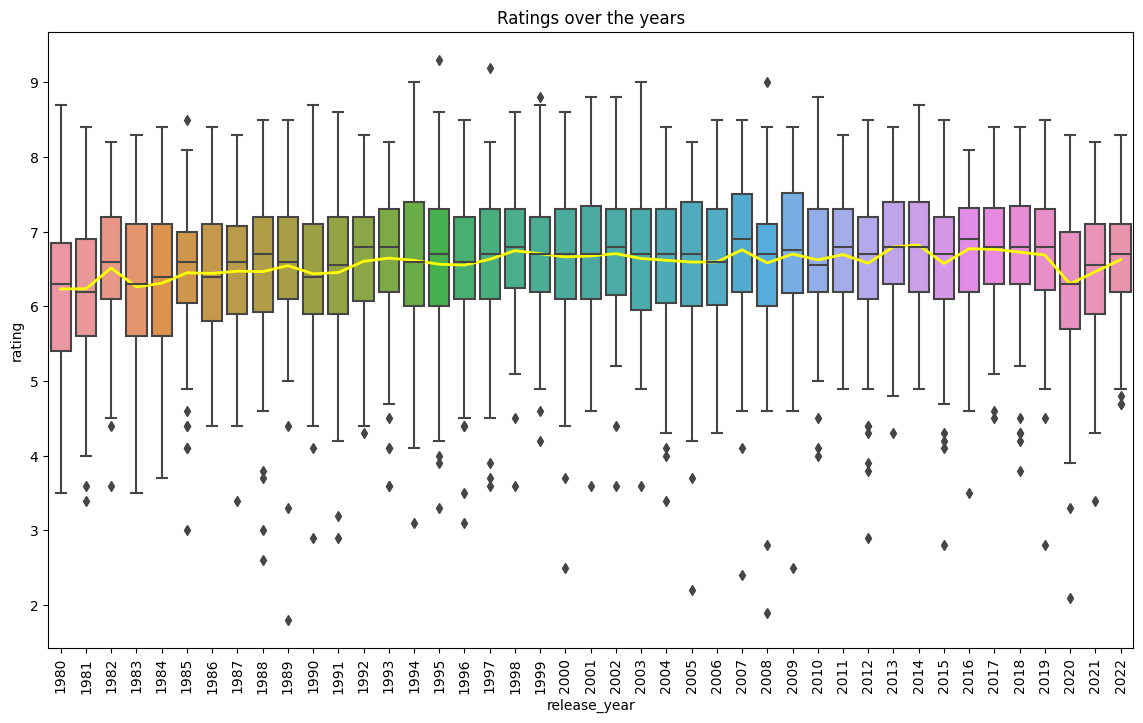

In [28]:
plt.figure(figsize=(14,8))
ax = sns.boxplot(data = data, x='release_year', y='rating')

means = data.groupby('release_year')['rating'].mean()
plt.plot(range(len(means)), means, color='yellow', linestyle='-', linewidth=2)

for item in ax.get_xticklabels():
    item.set_rotation(90)

plt.title("Ratings over the years")
plt.show()

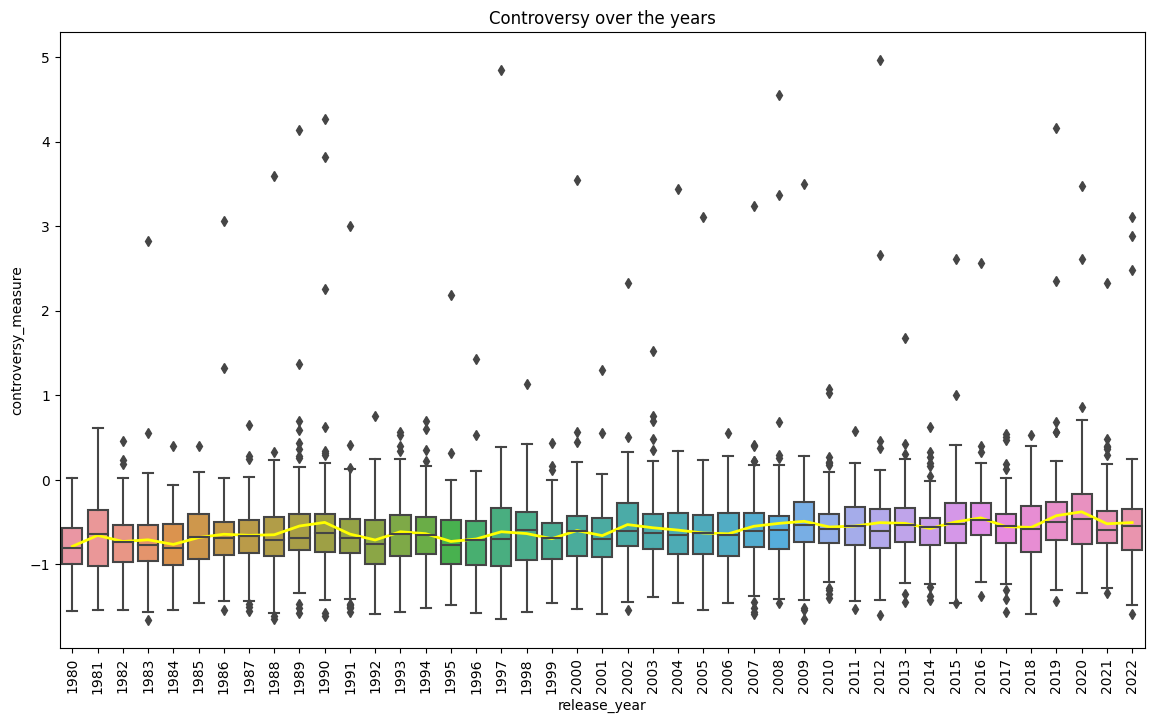

In [29]:
plt.figure(figsize=(14,8))
ax = sns.boxplot(data = data, x='release_year', y='controversy_measure')

means = data.groupby('release_year')['controversy_measure'].mean()
plt.plot(range(len(means)), means, color='yellow', linestyle='-', linewidth=2)

for item in ax.get_xticklabels():
    item.set_rotation(90)

plt.title("Controversy over the years")
plt.show()

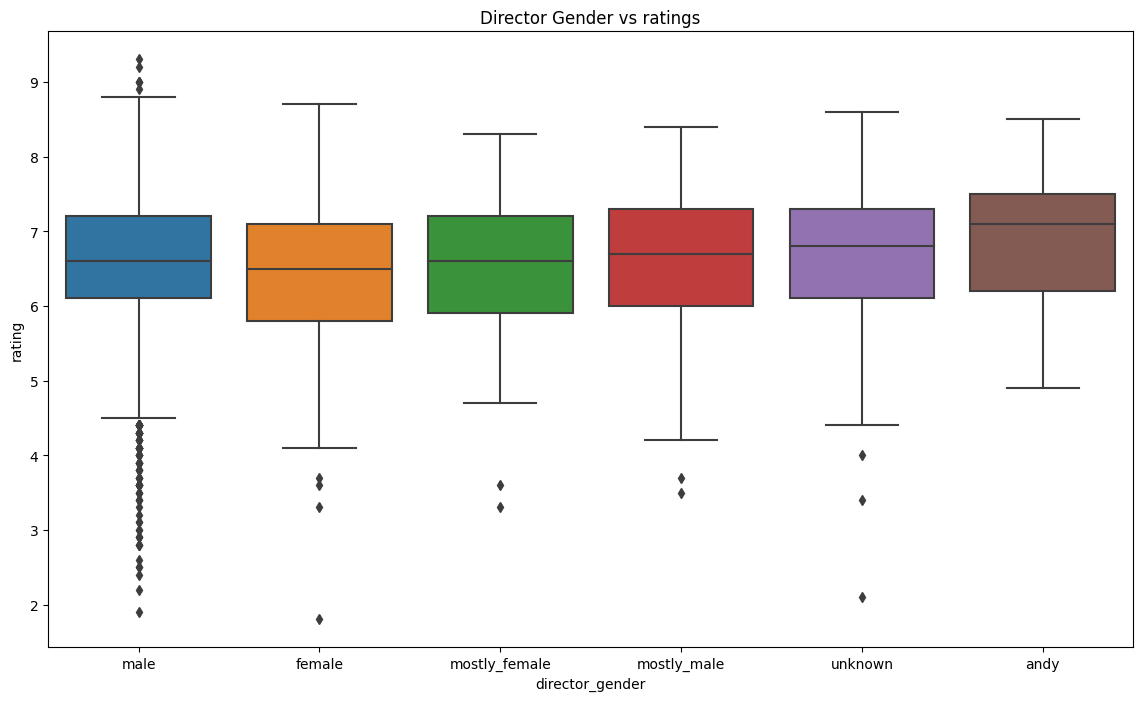

In [30]:
plt.figure(figsize=(14,8))
sns.boxplot(data = data, x='director_gender', y='rating')

plt.title("Director Gender vs ratings")
plt.show()

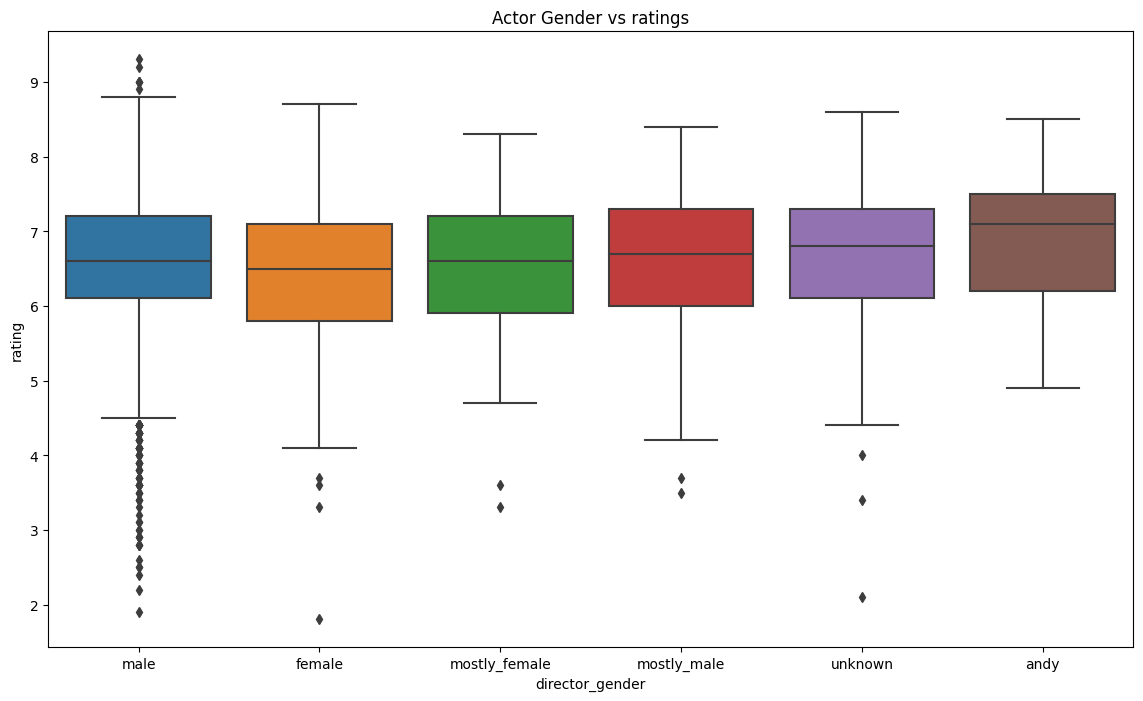

In [31]:
plt.figure(figsize=(14,8))
sns.boxplot(data = data, x='director_gender', y='rating')

plt.title("Actor Gender vs ratings")
plt.show()